In [1]:
#Improt libraries
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt        # create visualizations
import geopandas as gpd
import shapely.geometry 
import earthpy.plot as ep
import earthpy.spatial as es
import os

In [2]:
#PRE IMAGE

# Open the Landsat image using rasterio
with rio.open('../raw_data/stacked_clipped_20230601.tif') as src:
    image_pre = src.read()
    r_pre = src.read(3) #Red band
    g_pre = src.read(2)  # Green band
    b_pre = src.read(1) #Blue band
    nir_pre = src.read(4)  # Near-infrared band

stacked_pre = np.stack([r_pre, g_pre, b_pre, nir_pre], axis=-1)
rgb_pre = stacked_pre.astype(np.uint8)[...,[0,1,2]]


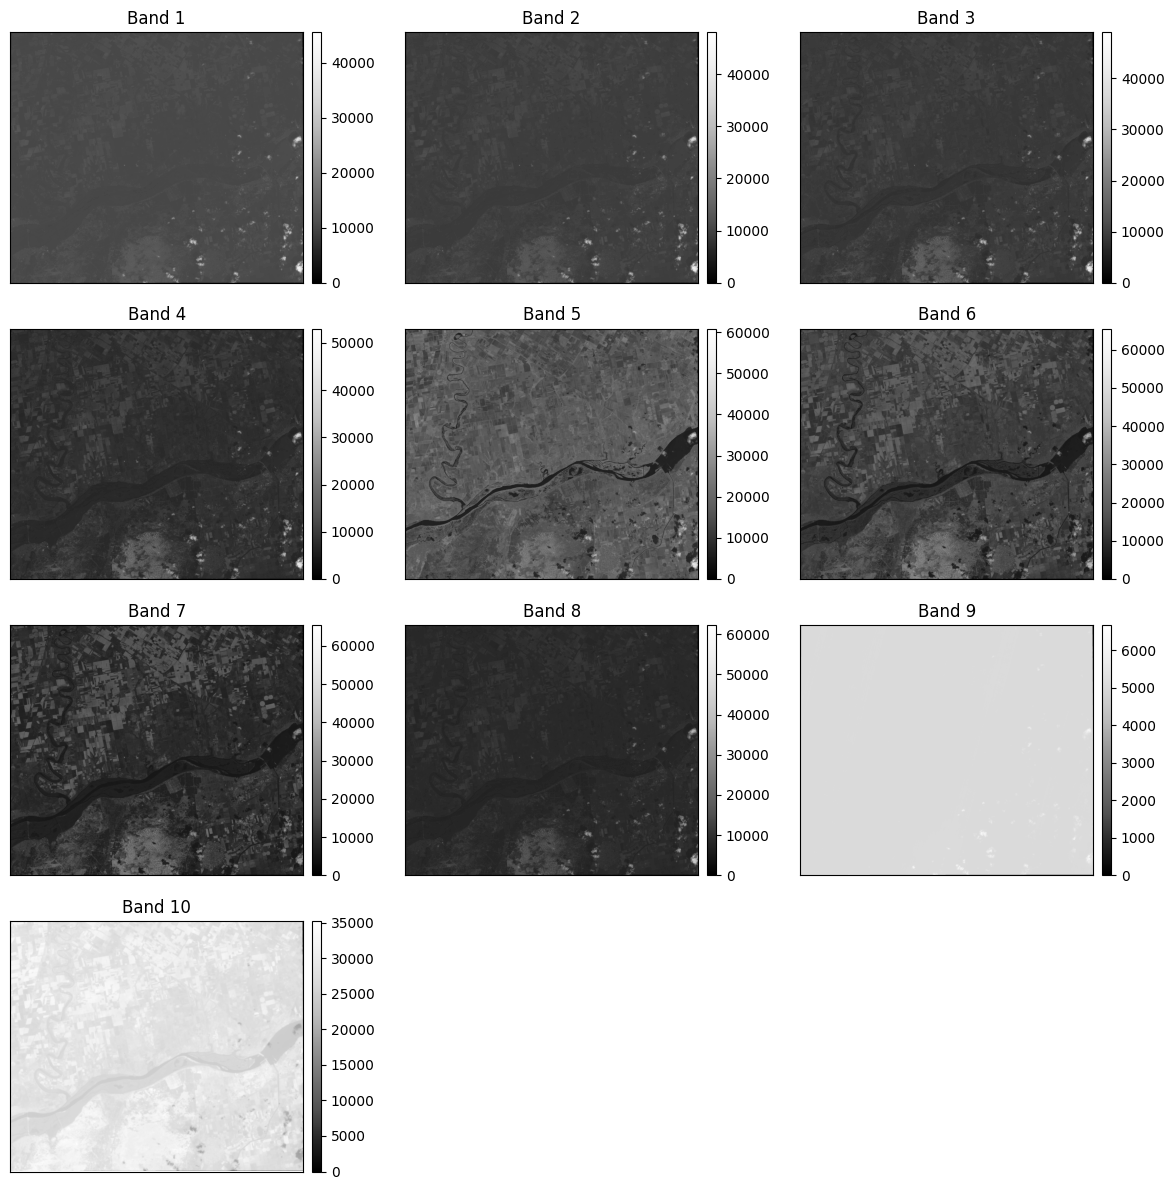

array([[<Axes: title={'center': 'Band 1'}>,
        <Axes: title={'center': 'Band 2'}>,
        <Axes: title={'center': 'Band 3'}>],
       [<Axes: title={'center': 'Band 4'}>,
        <Axes: title={'center': 'Band 5'}>,
        <Axes: title={'center': 'Band 6'}>],
       [<Axes: title={'center': 'Band 7'}>,
        <Axes: title={'center': 'Band 8'}>,
        <Axes: title={'center': 'Band 9'}>],
       [<Axes: title={'center': 'Band 10'}>, <Axes: >, <Axes: >]],
      dtype=object)

In [3]:
ep.plot_bands(image_pre)

In [4]:
#POST IMAGE

# Open the Landsat image using rasterio
with rio.open('../raw_data/stacked_clipped_20230703.tif') as src:
    image_post = src.read()
    r_post = src.read(3) #Red band
    g_post = src.read(2)  # Green band
    b_post = src.read(1) #Blue band
    nir_post = src.read(4)  # Near-infrared band

stacked_post = np.stack([r_post, g_post, b_post, nir_post], axis=-1)
rgb_post = stacked_post.astype(np.uint32)[...,[0,1,2]]

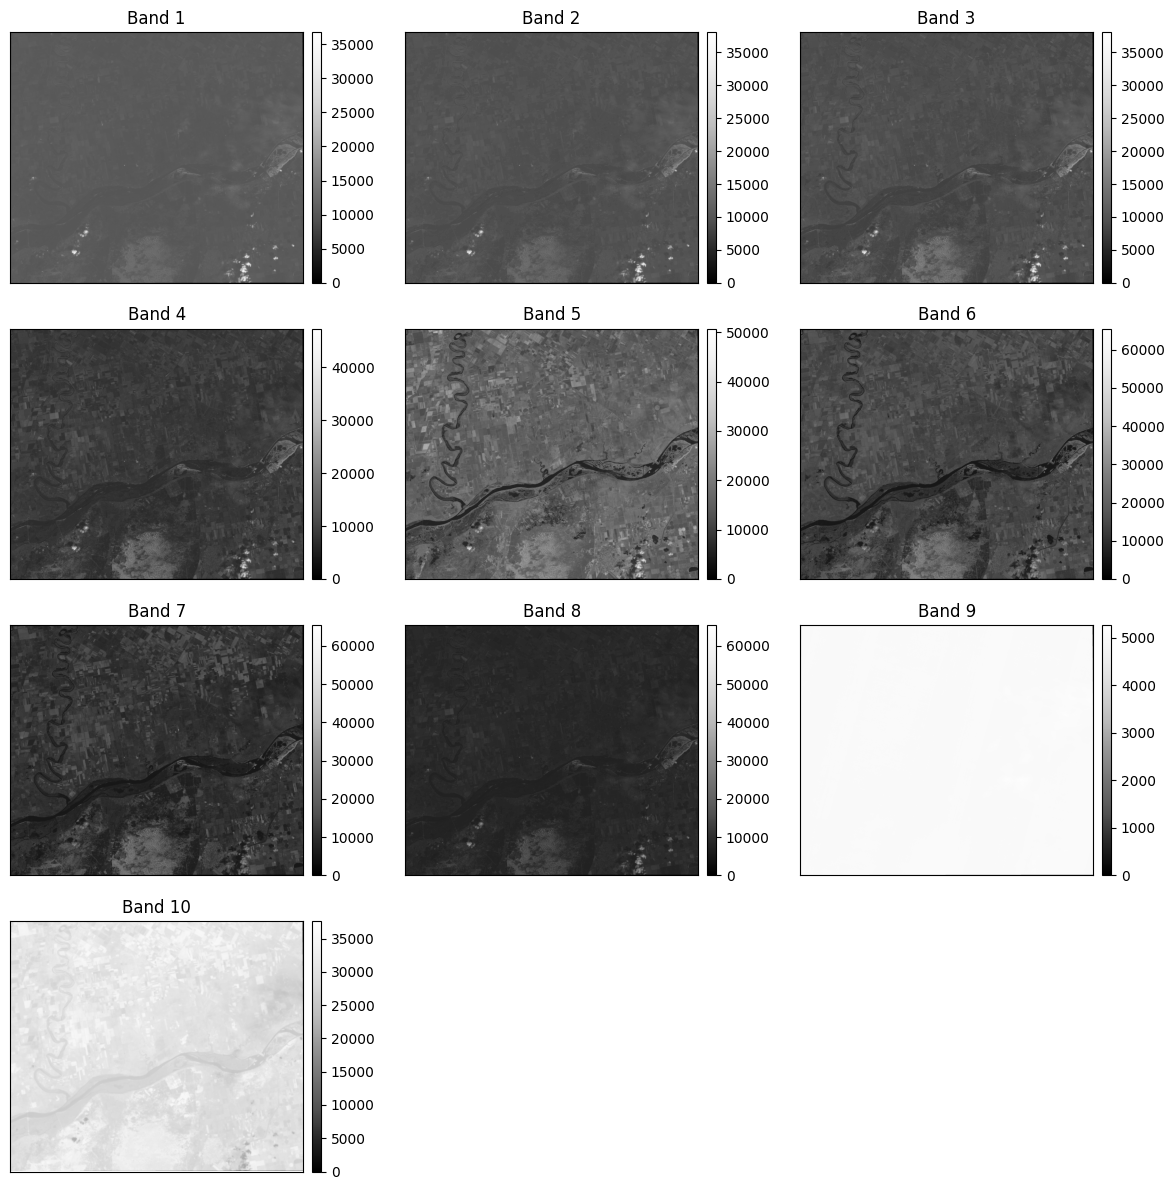

array([[<Axes: title={'center': 'Band 1'}>,
        <Axes: title={'center': 'Band 2'}>,
        <Axes: title={'center': 'Band 3'}>],
       [<Axes: title={'center': 'Band 4'}>,
        <Axes: title={'center': 'Band 5'}>,
        <Axes: title={'center': 'Band 6'}>],
       [<Axes: title={'center': 'Band 7'}>,
        <Axes: title={'center': 'Band 8'}>,
        <Axes: title={'center': 'Band 9'}>],
       [<Axes: title={'center': 'Band 10'}>, <Axes: >, <Axes: >]],
      dtype=object)

In [5]:
ep.plot_bands(image_post)

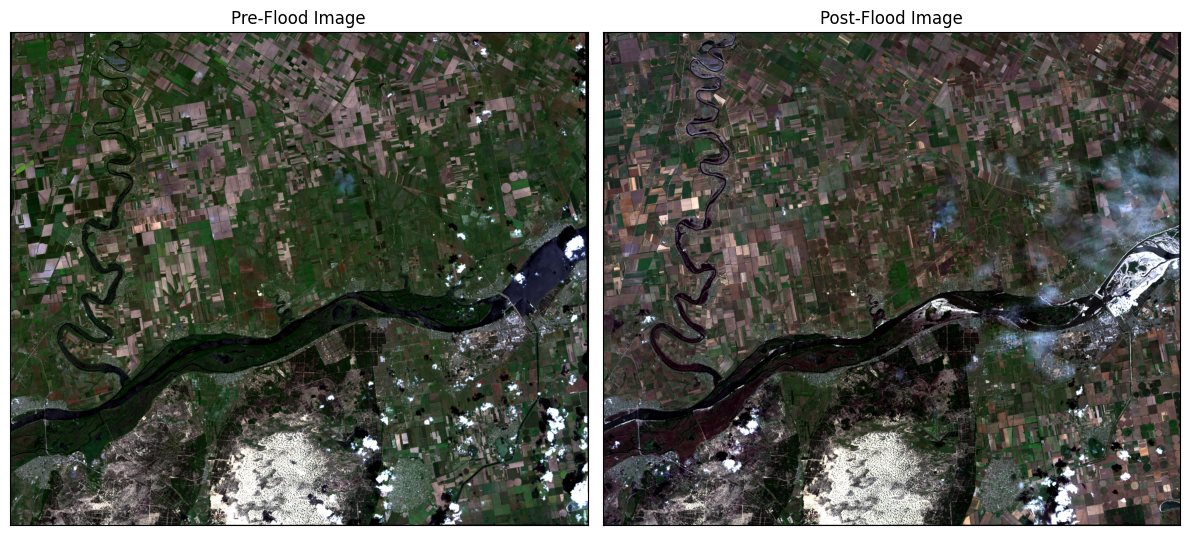

In [6]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the pre_image on the first subplot
pre_image_rgb = ep.plot_rgb(image_pre, 
                            rgb=(3, 2, 1),  # Red, Green, Blue bands
                            stretch=True, 
                            ax=ax1)
ax1.set_title('Pre-Flood Image')

# Plot the post_image on the second subplot
post_image_rgb = ep.plot_rgb(image_post, 
                             rgb=(3, 2, 1),  # Red, Green, Blue bands
                             stretch=True, 
                             ax=ax2)
ax2.set_title('Post-Flood Image')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [7]:
r_pre = image_pre[3]
g_pre = image_pre[2]
b_pre = image_pre[1]
nir_pre = image_pre[4]
swir_pre = image_pre[5]

r_post = image_post[3]
g_post = image_post[2]
b_post = image_post[1]
nir_post = image_post[4]
swir_post = image_post[5]

In [8]:
def get_ndwi(green_band, swir_band):
    # Calculate the sum of the green_band and swir_band
    denominator = green_band + swir_band
    
    # Handle division by zero and NaN values
    ndwi = np.divide((green_band - swir_band), denominator, 
                     where=denominator != 0, 
                     out=np.full_like(denominator, np.nan, dtype=np.float32))
    
    return ndwi


In [9]:
# Calculate NDWI for both images
ndwi_pre = get_ndwi(g_pre, swir_pre)
ndwi_post = get_ndwi(g_post, swir_post)

In [10]:
# Create water masks for pre-flood and post-flood images
water_mask_pre = ndwi_pre > 0.3
water_mask_post = ndwi_post > 0.3

# Calculate water pixel difference between post and pre images
flooded_pixels = np.logical_and(water_mask_post, np.logical_not(water_mask_pre))

In [11]:
#get notebook directory
notebook_directory = os.path.abspath('.')

print("Notebook directory:", notebook_directory)

#create output directory path if it doesnt exist
output_directory = os.path.join(notebook_directory, 'output/')
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

print("Output directory:", output_directory)

# Convert the boolean array to integers (0 for False, 1 for True)
flooded_pixels = flooded_pixels.astype(np.uint8)

# Save the new raster to output directory
with rio.Env():
    # Create a new raster with the same metadata as the original, but with a single band
    with rio.open(os.path.join(output_directory, 'flooded_raster.tif'), 'w', 
                       driver='GTiff', 
                       height=flooded_pixels.shape[0], 
                       width=flooded_pixels.shape[1], 
                       count=1, 
                       dtype=flooded_pixels.dtype,
                       crs=src.crs, 
                       transform=src.transform) as dst:
        # Write the flooded_pixels array to the raster
        dst.write(flooded_pixels, 1)
    print("Raster creation and writing completed.")


Notebook directory: C:\Users\turki\satellite_flood_detection\notebooks
Output directory: C:\Users\turki\satellite_flood_detection\notebooks\output/
Raster creation and writing completed.


### Vectorize flooded pixels


In [13]:
#open image
with rio.open('output/flooded_raster.tif') as src:
    raster_data = src.read(1)
    transform = src.transform

#get pixels ==1 (flooded)
features_gen = rio.features.shapes(raster_data, mask=raster_data == 1, transform=transform)

#convert pixels to shapely geom
geometries = [shapely.geometry.shape(feature) for feature, _ in features_gen]

#store geoms in gdf
gdf = gpd.GeoDataFrame(geometry=geometries, crs=src.crs)

#save gdf to geojson
output_vector_file = 'output/flooded_vector.geojson'
gdf.to_file(output_vector_file, driver='GeoJSON')

print(f"Saved flooded vector file: {output_vector_file}")


Saved flooded vector file: output/flooded_vector.geojson
